In [0]:
pip install tweepy nltk pandas spacy TextBlob

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 52.3 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [0]:
import re
import spacy
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from textblob import TextBlob
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## 1. Collecte tweets nettoyés depuis le dépôt Github

In [0]:
%fs cp "https://raw.githubusercontent.com/Jh2David/analyse-de-sentiments/main/data/tweets_filtered.csv" "/data/tweets_filtered.csv"

res0: Boolean = true

In [0]:
%fs ls /data

path,name,size,modificationTime
dbfs:/data/sentiment_analysis.parquet/,sentiment_analysis.parquet/,0,1715030362000
dbfs:/data/tweets.csv,tweets.csv,4180,1715020393000
dbfs:/data/tweets_filtered.csv,tweets_filtered.csv,13353,1715071188000


In [0]:
# Charger les données du notebook 1
df = spark.read.format("csv").option("header", "true").load("dbfs:/data/tweets_filtered.csv")

In [0]:
display(df)

text,text_cleaned,tweet_lemmatized,tokens,filtered_tokens
Red Bull team boss Christian Horner says Adrian Newey’s exit from the team does not allow Max Verstappen to get out of his contract. #F1 #RedBull #MiamiGP https://t.co/UBp4sdin4h,red bull team boss christian horner says adrian neweys exit from the team does not allow max verstappen to get out of his contract,red bull team boss christian horner say adrian neweys exit from the team do not allow max verstappen to get out of his contract,"['red', 'bull', 'team', 'boss', 'christian', 'horner', 'say', 'adrian', 'neweys', 'exit', 'from', 'the', 'team', 'do', 'not', 'allow', 'max', 'verstappen', 'to', 'get', 'out', 'of', 'his', 'contract']","['red', 'bull', 'team', 'boss', 'christian', 'horner', 'say', 'adrian', 'neweys', 'exit', 'team', 'allow', 'max', 'verstappen', 'get', 'contract']"
"Surprisingly, Red Bull allowed Adrian Newey to get out of his contract early, without having to serve a period of ‘gardening leave’. Team boss Christian Horner reveals why. #F1 #RedBull #MiamiGP https://t.co/2gJTQZeULN",surprisingly red bull allowed adrian newey to get out of his contract early without having to serve a period of gardening leave team boss christian horner reveals why,surprisingly red bull allow adrian newey to get out of his contract early without have to serve a period of gardening leave team boss christian horner reveal why,"['surprisingly', 'red', 'bull', 'allow', 'adrian', 'newey', 'to', 'get', 'out', 'of', 'his', 'contract', 'early', 'without', 'have', 'to', 'serve', 'a', 'period', 'of', 'gardening', 'leave', 'team', 'boss', 'christian', 'horner', 'reveal', 'why']","['surprisingly', 'red', 'bull', 'allow', 'adrian', 'newey', 'get', 'contract', 'early', 'without', 'serve', 'period', 'gardening', 'leave', 'team', 'boss', 'christian', 'horner', 'reveal']"
"Christian Horner says Adrian Newey is “not leaving the company, but stepping aside from Formula 1”, and “it’s been something that we’ve been having to plan for”. #F1 #RedBull #MiamiGP https://t.co/QFMBmrJhrz",christian horner says adrian newey is not leaving the company but stepping aside from formula 1 and its been something that weve been having to plan for,christian horner say adrian newey be not leave the company but step aside from formula 1 and its be something that we ve be have to plan for,"['christian', 'horner', 'say', 'adrian', 'newey', 'be', 'not', 'leave', 'the', 'company', 'but', 'step', 'aside', 'from', 'formula', '1', 'and', 'its', 'be', 'something', 'that', 'we', 've', 'be', 'have', 'to', 'plan', 'for']","['christian', 'horner', 'say', 'adrian', 'newey', 'leave', 'company', 'step', 'aside', 'formula', '1', 'something', 'plan']"
Red Bull team principal Christian Horner emphasizes that Adrian Newey's departure is not driven by internal tensions. Maintaining a united front amid speculations is crucial for the team's ongoing success. #RedBull #F1 https://t.co/KnpEBX8lZ1,red bull team principal christian horner emphasizes that adrian neweys departure is not driven by internal tensions maintaining a united front amid speculations is crucial for the teams ongoing success,red bull team principal christian horner emphasize that adrian newey departure be not drive by internal tension maintain a united front amid speculation be crucial for the team ongoing success,"['red', 'bull', 'team', 'principal', 'christian', 'horner', 'emphasize', 'that', 'adrian', 'newey', 'departure', 'be', 'not', 'drive', 'by', 'internal', 'tension', 'maintain', 'a', 'united', 'front', 'amid', 'speculation', 'be', 'crucial', 'for', 'the', 'team', 'ongoing', 'success']","['red', 'bull', 'team', 'principal', 'christian', 'horner', 'emphasize', 'adrian', 'newey', 'departure', 'drive', 'internal', 'tension', 'maintain', 'united', 'front', 'amid', 'speculation', 'crucial', 'team', 'ongoing', 'success']"
"Well…Helmut Marko certainly has a difference of opinion to Christian Horner and many others, in regard to how important Adrian Newey was to the t

# 2. Analyse des sentiments

## 2.1 Spark session initialisation

In [0]:
spark = SparkSession.builder \
    .appName("TwitterSentimentAnalysis") \
    .getOrCreate()

## 2.2 Fonction d'analyse des sentiments

In [0]:
# Analyse de sentiments avec TextBlob
def analyze_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    if sentiment > 0:
        return "positif"
    elif sentiment < 0:
        return "négatif"
    else:
        return "neutre"

### 2.3 Analyse

In [0]:
sentiment_udf = udf(analyze_sentiment, StringType())
df = df.withColumn("sentiment", sentiment_udf(("filtered_tokens")))

In [0]:
display(df)

text,text_cleaned,tweet_lemmatized,tokens,filtered_tokens,sentiment
Red Bull team boss Christian Horner says Adrian Newey’s exit from the team does not allow Max Verstappen to get out of his contract. #F1 #RedBull #MiamiGP https://t.co/UBp4sdin4h,red bull team boss christian horner says adrian neweys exit from the team does not allow max verstappen to get out of his contract,red bull team boss christian horner say adrian neweys exit from the team do not allow max verstappen to get out of his contract,"['red', 'bull', 'team', 'boss', 'christian', 'horner', 'say', 'adrian', 'neweys', 'exit', 'from', 'the', 'team', 'do', 'not', 'allow', 'max', 'verstappen', 'to', 'get', 'out', 'of', 'his', 'contract']","['red', 'bull', 'team', 'boss', 'christian', 'horner', 'say', 'adrian', 'neweys', 'exit', 'team', 'allow', 'max', 'verstappen', 'get', 'contract']",neutre
"Surprisingly, Red Bull allowed Adrian Newey to get out of his contract early, without having to serve a period of ‘gardening leave’. Team boss Christian Horner reveals why. #F1 #RedBull #MiamiGP https://t.co/2gJTQZeULN",surprisingly red bull allowed adrian newey to get out of his contract early without having to serve a period of gardening leave team boss christian horner reveals why,surprisingly red bull allow adrian newey to get out of his contract early without have to serve a period of gardening leave team boss christian horner reveal why,"['surprisingly', 'red', 'bull', 'allow', 'adrian', 'newey', 'to', 'get', 'out', 'of', 'his', 'contract', 'early', 'without', 'have', 'to', 'serve', 'a', 'period', 'of', 'gardening', 'leave', 'team', 'boss', 'christian', 'horner', 'reveal', 'why']","['surprisingly', 'red', 'bull', 'allow', 'adrian', 'newey', 'get', 'contract', 'early', 'without', 'serve', 'period', 'gardening', 'leave', 'team', 'boss', 'christian', 'horner', 'reveal']",positif
"Christian Horner says Adrian Newey is “not leaving the company, but stepping aside from Formula 1”, and “it’s been something that we’ve been having to plan for”. #F1 #RedBull #MiamiGP https://t.co/QFMBmrJhrz",christian horner says adrian newey is not leaving the company but stepping aside from formula 1 and its been something that weve been having to plan for,christian horner say adrian newey be not leave the company but step aside from formula 1 and its be something that we ve be have to plan for,"['christian', 'horner', 'say', 'adrian', 'newey', 'be', 'not', 'leave', 'the', 'company', 'but', 'step', 'aside', 'from', 'formula', '1', 'and', 'its', 'be', 'something', 'that', 'we', 've', 'be', 'have', 'to', 'plan', 'for']","['christian', 'horner', 'say', 'adrian', 'newey', 'leave', 'company', 'step', 'aside', 'formula', '1', 'something', 'plan']",neutre
Red Bull team principal Christian Horner emphasizes that Adrian Newey's departure is not driven by internal tensions. Maintaining a united front amid speculations is crucial for the team's ongoing success. #RedBull #F1 https://t.co/KnpEBX8lZ1,red bull team principal christian horner emphasizes that adrian neweys departure is not driven by internal tensions maintaining a united front amid speculations is crucial for the teams ongoing success,red bull team principal christian horner emphasize that adrian newey departure be not drive by internal tension maintain a united front amid speculation be crucial for the team ongoing success,"['red', 'bull', 'team', 'principal', 'christian', 'horner', 'emphasize', 'that', 'adrian', 'newey', 'departure', 'be', 'not', 'drive', 'by', 'internal', 'tension', 'maintain', 'a', 'united', 'front', 'amid', 'speculation', 'be', 'crucial', 'for', 'the', 'team', 'ongoing', 'success']","['red', 'bull', 'team', 'principal', 'christian', 'horner', 'emphasize', 'adrian', 'newey', 'departure', 'drive', 'internal', 'tension', 'maintain', 'united', 'front', 'amid', 'speculation', 'crucial', 'team', 'ongoing', 'success']",positif
"Well…Helmut Marko certainly has a difference of opinion to Christian Horner and many others, in regard to

In [0]:
df.write.mode("overwrite").saveAsTable("sentiment_analysis")

In [0]:
%sql
SELECT * FROM sentiment_analysis

text,text_cleaned,tweet_lemmatized,tokens,filtered_tokens,sentiment
Red Bull team boss Christian Horner says Adrian Newey’s exit from the team does not allow Max Verstappen to get out of his contract. #F1 #RedBull #MiamiGP https://t.co/UBp4sdin4h,red bull team boss christian horner says adrian neweys exit from the team does not allow max verstappen to get out of his contract,red bull team boss christian horner say adrian neweys exit from the team do not allow max verstappen to get out of his contract,"['red', 'bull', 'team', 'boss', 'christian', 'horner', 'say', 'adrian', 'neweys', 'exit', 'from', 'the', 'team', 'do', 'not', 'allow', 'max', 'verstappen', 'to', 'get', 'out', 'of', 'his', 'contract']","['red', 'bull', 'team', 'boss', 'christian', 'horner', 'say', 'adrian', 'neweys', 'exit', 'team', 'allow', 'max', 'verstappen', 'get', 'contract']",neutre
"Surprisingly, Red Bull allowed Adrian Newey to get out of his contract early, without having to serve a period of ‘gardening leave’. Team boss Christian Horner reveals why. #F1 #RedBull #MiamiGP https://t.co/2gJTQZeULN",surprisingly red bull allowed adrian newey to get out of his contract early without having to serve a period of gardening leave team boss christian horner reveals why,surprisingly red bull allow adrian newey to get out of his contract early without have to serve a period of gardening leave team boss christian horner reveal why,"['surprisingly', 'red', 'bull', 'allow', 'adrian', 'newey', 'to', 'get', 'out', 'of', 'his', 'contract', 'early', 'without', 'have', 'to', 'serve', 'a', 'period', 'of', 'gardening', 'leave', 'team', 'boss', 'christian', 'horner', 'reveal', 'why']","['surprisingly', 'red', 'bull', 'allow', 'adrian', 'newey', 'get', 'contract', 'early', 'without', 'serve', 'period', 'gardening', 'leave', 'team', 'boss', 'christian', 'horner', 'reveal']",positif
"Christian Horner says Adrian Newey is “not leaving the company, but stepping aside from Formula 1”, and “it’s been something that we’ve been having to plan for”. #F1 #RedBull #MiamiGP https://t.co/QFMBmrJhrz",christian horner says adrian newey is not leaving the company but stepping aside from formula 1 and its been something that weve been having to plan for,christian horner say adrian newey be not leave the company but step aside from formula 1 and its be something that we ve be have to plan for,"['christian', 'horner', 'say', 'adrian', 'newey', 'be', 'not', 'leave', 'the', 'company', 'but', 'step', 'aside', 'from', 'formula', '1', 'and', 'its', 'be', 'something', 'that', 'we', 've', 'be', 'have', 'to', 'plan', 'for']","['christian', 'horner', 'say', 'adrian', 'newey', 'leave', 'company', 'step', 'aside', 'formula', '1', 'something', 'plan']",neutre
Red Bull team principal Christian Horner emphasizes that Adrian Newey's departure is not driven by internal tensions. Maintaining a united front amid speculations is crucial for the team's ongoing success. #RedBull #F1 https://t.co/KnpEBX8lZ1,red bull team principal christian horner emphasizes that adrian neweys departure is not driven by internal tensions maintaining a united front amid speculations is crucial for the teams ongoing success,red bull team principal christian horner emphasize that adrian newey departure be not drive by internal tension maintain a united front amid speculation be crucial for the team ongoing success,"['red', 'bull', 'team', 'principal', 'christian', 'horner', 'emphasize', 'that', 'adrian', 'newey', 'departure', 'be', 'not', 'drive', 'by', 'internal', 'tension', 'maintain', 'a', 'united', 'front', 'amid', 'speculation', 'be', 'crucial', 'for', 'the', 'team', 'ongoing', 'success']","['red', 'bull', 'team', 'principal', 'christian', 'horner', 'emphasize', 'adrian', 'newey', 'departure', 'drive', 'internal', 'tension', 'maintain', 'united', 'front', 'amid', 'speculation', 'crucial', 'team', 'ongoing', 'success']",positif
"Well…Helmut Marko certainly has a difference of opinion to Christian Horner and many others, in regard to

Databricks visualization. Run in Databricks to view.

In [0]:
pip install matplotlib seaborn

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


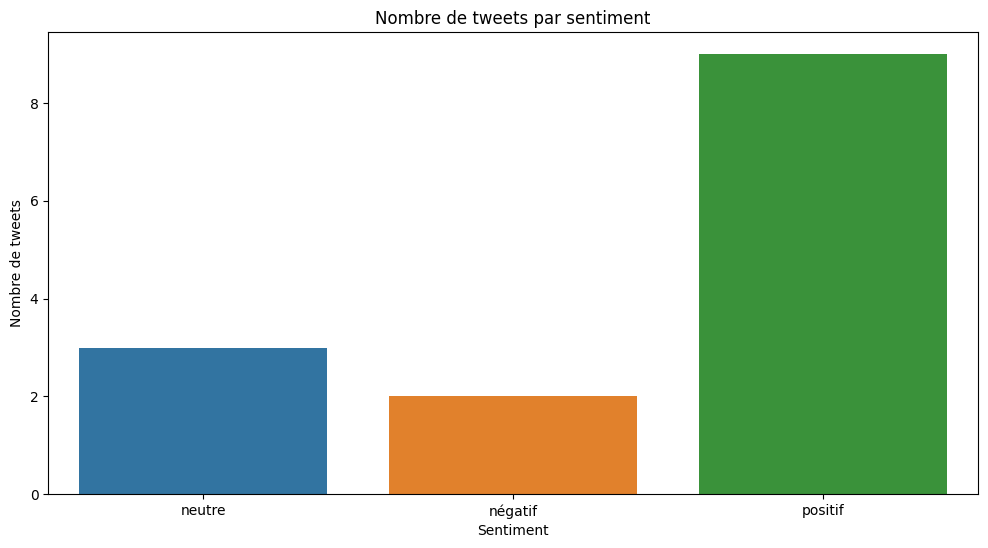

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calcul du nombre de tweets par sentiment
df_pandas = df.toPandas()
sentiment_counts = df_pandas.groupby('sentiment')['text'].count().reset_index()

# Création du graphique
plt.figure(figsize=(12, 6))
sns.barplot(x='sentiment', y='text', data=sentiment_counts)
plt.title('Nombre de tweets par sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Nombre de tweets')
plt.show()


In [0]:
pip install WordCloud

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 7.7 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


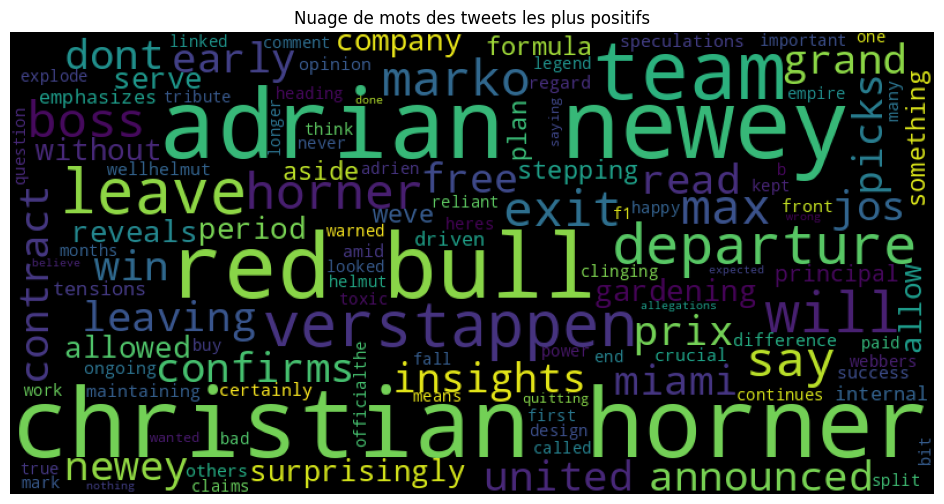

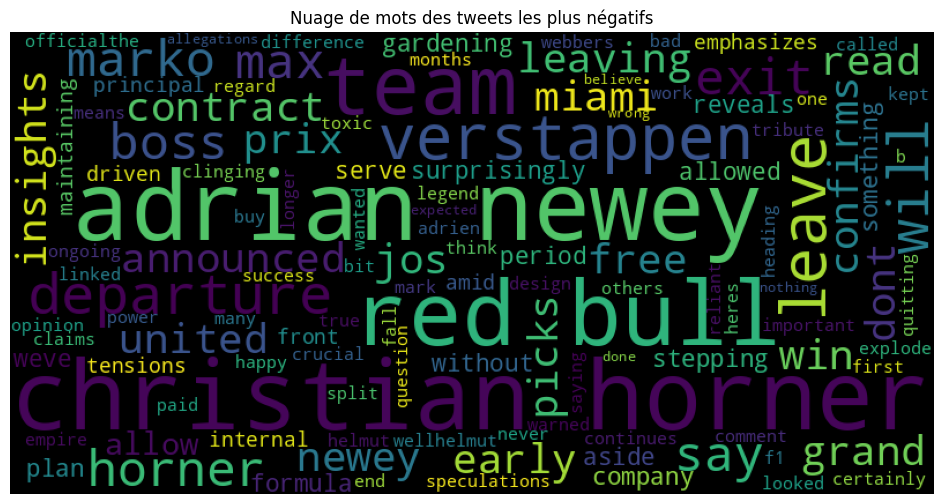

In [0]:
from wordcloud import WordCloud

# Convert 'sentiment' column to numeric dtype
df_pandas['sentiment'] = pd.to_numeric(df_pandas['sentiment'], errors='coerce')

# Sélection des tweets les plus positifs et négatifs
top_positive = df_pandas.nlargest(50, 'sentiment')
top_negative = df_pandas.nsmallest(50, 'sentiment')

# Création des nuages de mots
plt.figure(figsize=(12, 6))
wc = WordCloud(width=800, height=400).generate(' '.join(top_positive['text_cleaned']))
plt.imshow(wc)
plt.title('Nuage de mots des tweets les plus positifs')
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))
wc = WordCloud(width=800, height=400).generate(' '.join(top_negative['text_cleaned']))
plt.imshow(wc)
plt.title('Nuage de mots des tweets les plus négatifs')
plt.axis('off')
plt.show()

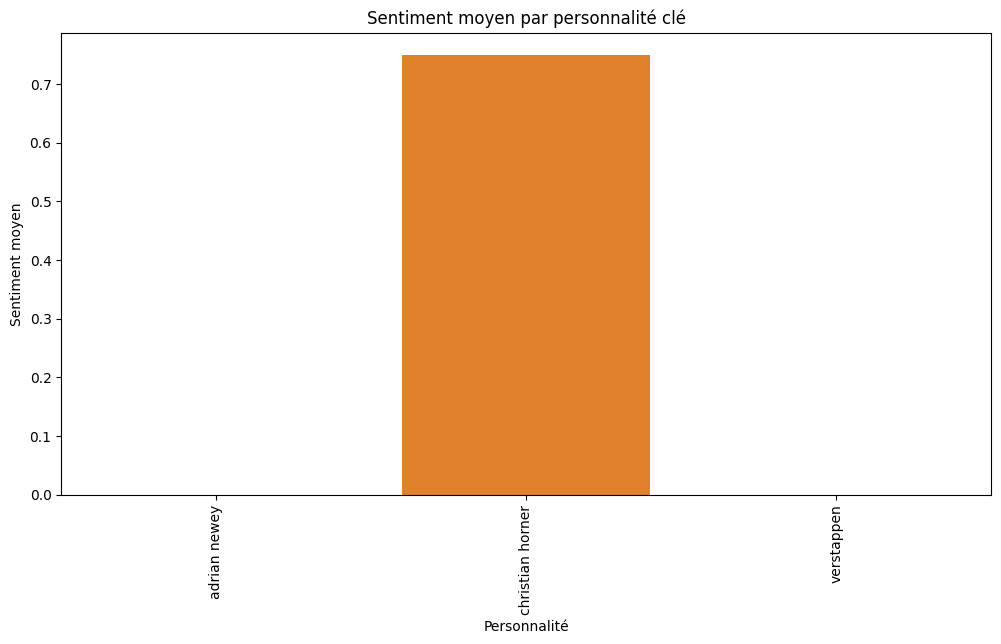

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Conversion des valeurs de sentiment en valeurs numériques
sentiment_map = {'positif': 1, 'neutre': 0, 'négatif': -1}
df_pandas['sentiment_num'] = df_pandas['sentiment'].map(sentiment_map)

# Calcul du sentiment moyen par personnalité
sentiment_by_entity = df_pandas[df_pandas['text_cleaned'].str.contains('christian horner|adrian newey|verstappen')] \
                     .groupby(df_pandas['text_cleaned'].str.extract(r'(christian horner|adrian newey|verstappen)', expand=False))['sentiment_num'] \
                     .mean().reset_index()

# Création du graphique
plt.figure(figsize=(12, 6))
sns.barplot(x='text_cleaned', y='sentiment_num', data=sentiment_by_entity)
plt.title('Sentiment moyen par personnalité clé')
plt.xlabel('Personnalité')
plt.ylabel('Sentiment moyen')
plt.xticks(rotation=90)
plt.show()
